# Try with Statsforecast

In [42]:
import random
import time
from multiprocessing import cpu_count, Pool # for prophet
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsforecast.core import StatsForecast
from statsforecast.models import seasonal_naive, seasonal_exponential_smoothing, seasonal_window_average, ses
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import ParameterGrid

In [55]:
from statsforecast.arima import auto_arima_f, forecast_arima

#https://github.com/Nixtla/statsforecast/blob/356bd9acf7b18a9a345bc9dc213f95b66047ea09/statsforecast/arima.py#L2136
def auto_arima(X: np.ndarray, h: int, future_xreg=None, season_length: int = 1,
               approximation: bool = False, level = None) -> np.ndarray:
    y = X[:, 0] if X.ndim == 2 else X
    xreg = X[:, 1:] if (X.ndim == 2 and X.shape[1] > 1) else None
    mod = auto_arima_f(
        y,
        xreg=xreg,
        period=season_length,
        approximation=approximation,
        allowmean=False, allowdrift=False, #not implemented yet
        ##EXTRA PARAMETERS HERE
                        d=1,
                        D=1,
                        max_p=2,
                        max_q=2,
                        max_P=2,
                        max_Q=2,
                        start_p=1,
                        start_q=1,
                        start_P=1,
                        start_Q=1,
                        stationary=False,
                        seasonal=True,
                        ic='aicc',
                        stepwise=True,
                        nmodels=5,
                        trace=False,
                        method=None,
                        truncate=None,
                        test='kpss',
                        test_kwargs=None,
                        seasonal_test='seas',
                        seasonal_test_kwargs=None,
                        blambda=None,
                        biasadj=False,
                        parallel=False,
                        num_cores=None,
    )
    fcst = forecast_arima(mod, h, xreg=future_xreg, level=level)
    if level is None:
        return fcst['mean']
    return {
        'mean': fcst['mean'],
        **{f'lo-{l}': fcst['lower'][f'{l}%'] for l in reversed(level)},
        **{f'hi-{l}': fcst['upper'][f'{l}%'] for l in level},
    }

In [56]:
data =  pd.read_csv('../../../Data/pv_power_df_5day_capacity_scaled.csv', index_col='datetime').drop(columns=['2657', '2828']) #DROPPING FAULTY SYSTEMS
uk_pv = pd.read_csv('../../../Data/system_metadata_location_rounded.csv')
uk_pv['ss_id_string'] = uk_pv['ss_id'].astype('str')

In [57]:
n_train = 300
n_test = 24
n_series = 10
train = data.iloc[-n_train-n_test: -n_test , :n_series]
test = data.iloc[-n_test: , :n_series]

series_train = pd.DataFrame({'ds': np.tile(np.arange(n_train) , n_series),'y': train.values.T.flatten()}, 
                            index=pd.Index(np.repeat(test.columns, n_train), name='unique_id'))
series_test = pd.DataFrame({'ds': np.tile(np.arange(n_train, n_train + n_test) , n_series),'y': test.values.T.flatten()}, 
                            index=pd.Index(np.repeat(test.columns, n_test), name='unique_id'))

# n_train = 100
# n_test = 24
# n_series = 2
# train = data.iloc[-n_train-n_test: -n_test , :n_series]
# test = data.iloc[-n_test: , :n_series]
# ts = train.iloc[:,0:n_series]

# ts = ts.T.stack().to_frame().reset_index().set_index('level_0')
# ts = ts.rename(index={'level_0':'unique_id'}, columns = {'datetime':'ds', 0:'y'})
# ts.index = ts.index.rename('unique_id')
# ts


In [58]:
models = [ (auto_arima, 97, True) ]

fcst = StatsForecast(series_train, models=models, freq='5min', n_jobs=1)


In [59]:
init = time.time()
with np.errstate(invalid='ignore'):
    forecasts = fcst.forecast(n_test, level = (80, 95))
end = time.time()

time_nixtla = end - init
print(f'time it took is {time_nixtla}')


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/statsforecast/arima.py:878: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/statsforecast/arima.py:2074: UserWarning: Stepwise search was stopped early due to reaching the model number limit: nmodels=5
  warnings.warn(
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/statsforecast/arima.py:878: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/statsforecast/arima.py:2074: UserWarning: Stepwise search was stopped early due to reaching the model number limit: nmodels=5
  warnings.warn(
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/statsforecast/arima.py:2074: UserWarning: Stepwise search was stopped early due to reaching the model number limit: nmodels=5
  warnings.warn(
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/statsfore

time it took is 8.061672925949097


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/statsforecast/arima.py:2074: UserWarning: Stepwise search was stopped early due to reaching the model number limit: nmodels=5
  warnings.warn(


In [68]:
forecasts = forecasts.reset_index()
series_test = series_test.reset_index().merge(forecasts, how='left', on=['unique_id', 'ds'])

df_train = series_train.reset_index()
df_test = series_test

unique_ids = df_train['unique_id'].unique()

for uid in unique_ids:
    train_uid = df_train.query('unique_id == @uid')
    test_uid = df_test.query('unique_id == @uid')
    
    df_plot = pd.concat([train_uid, test_uid]).set_index('ds')
    df_plot[['y', 'auto_arima_season_length-97_approximation-True_mean_y']].plot(linewidth=2, figsize = (12,5))

    plt.fill_between(df_plot.index, 
                    df_plot['auto_arima_season_length-97_approximation-True_lo-80_y'], 
                    df_plot['auto_arima_season_length-97_approximation-True_hi-80_y'],
                    alpha=.35,
                    color='green',
                    label='auto_arima_level_80')
    plt.fill_between(df_plot.index, 
                    df_plot['auto_arima_season_length-97_approximation-True_lo-95_y'], 
                    df_plot['auto_arima_season_length-97_approximation-True_hi-95_y'],
                    alpha=.2,
                    color='green',
                    label='auto_arima_level_95')
    plt.title('PVE Forecast', fontsize=12)
    plt.ylabel('PVE pct Capacity', fontsize=12)
    plt.xlabel('Timestamp [t]', fontsize=12)
    plt.legend()
    plt.grid()


/var/folders/ry/13kbd8ws0q1935vwt56pkc8w0000gn/T/ipykernel_38546/3173909632.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'index_x'} in the result is deprecated and will raise a MergeError in a future version.
  series_test = series_test.reset_index().merge(forecasts, how='left', on=['unique_id', 'ds'])


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [45]:
n_train = 300
n_test = 100

train = data.iloc[-n_train-n_test: -n_test , 0]
test = data.iloc[-n_test: , 0]

series_train = pd.DataFrame({'ds': np.arange(len(train)),'y': train.values}, 
                            index=pd.Index([0] * train.size, name='unique_id'))

models = [ (auto_arima, 97) ]


fcst = StatsForecast(series_train, models=models, freq='5min', n_jobs=8)

init = time.time()
with np.errstate(invalid='ignore'):
    forecasts = fcst.forecast(n_test, level = (80, 95))
end = time.time()

time_nixtla = end - init
print(f'time it took is {time_nixtla}')
forecasts['y_test'] = test.values

time it took is 460.2373878955841


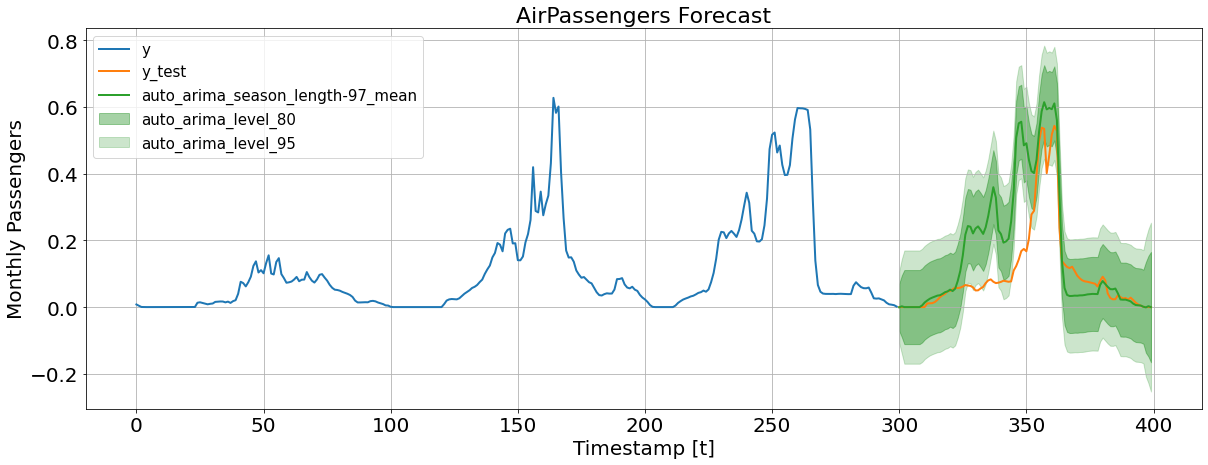

In [46]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
df_plot = pd.concat([series_train, forecasts]).set_index('ds')
df_plot[['y', 'y_test', 'auto_arima_season_length-97_mean']].plot(ax=ax, linewidth=2)
ax.fill_between(df_plot.index, 
                df_plot['auto_arima_season_length-97_lo-80'], 
                df_plot['auto_arima_season_length-97_hi-80'],
                alpha=.35,
                color='green',
                label='auto_arima_level_80')
ax.fill_between(df_plot.index, 
                df_plot['auto_arima_season_length-97_lo-95'], 
                df_plot['auto_arima_season_length-97_hi-95'],
                alpha=.2,
                color='green',
                label='auto_arima_level_95')
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)


## Seasonal Window Average

In [253]:
n_train = 300
n_test = 24
n_series = 10
train = data.iloc[-n_train-n_test: -n_test , :n_series]
test = data.iloc[-n_test: , :n_series]

series_train = pd.DataFrame({'ds': np.tile(np.arange(n_train) , n_series),'y': train.values.T.flatten()}, 
                            index=pd.Index(np.repeat(test.columns, n_train), name='unique_id'))
series_test = pd.DataFrame({'ds': np.tile(np.arange(n_train, n_train + n_test) , n_series),'y': test.values.T.flatten()}, 
                            index=pd.Index(np.repeat(test.columns, n_test), name='unique_id'))


models = [ (seasonal_window_average, 97, 2) ]
fcst = StatsForecast(series_train, models=models, freq='5min', n_jobs=8)

init = time.time()
with np.errstate(invalid='ignore'):
    forecasts = fcst.forecast(n_test, level = (80, 95))
end = time.time()

time_nixtla = end - init
print(f'time it took is {time_nixtla}')


time it took is 1.6625022888183594


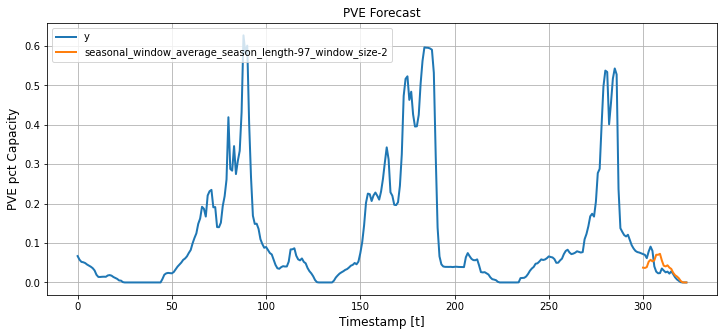

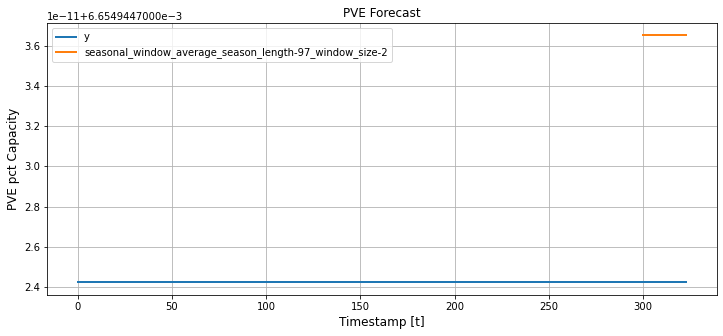

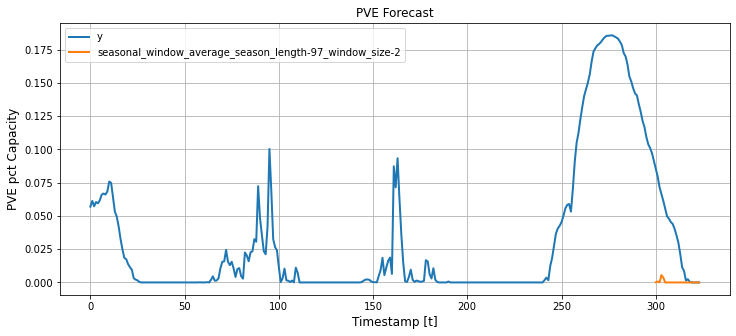

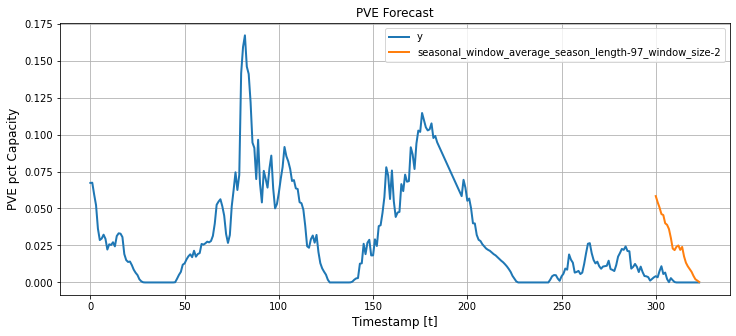

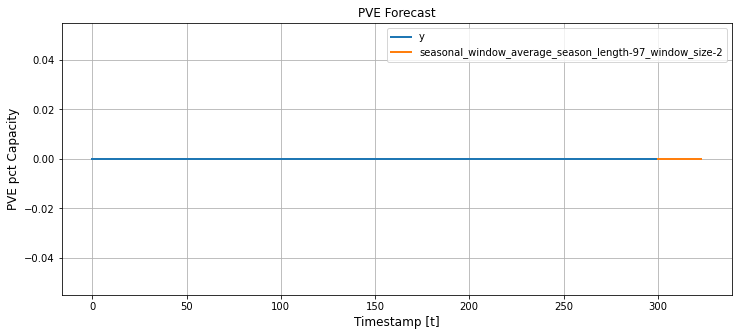

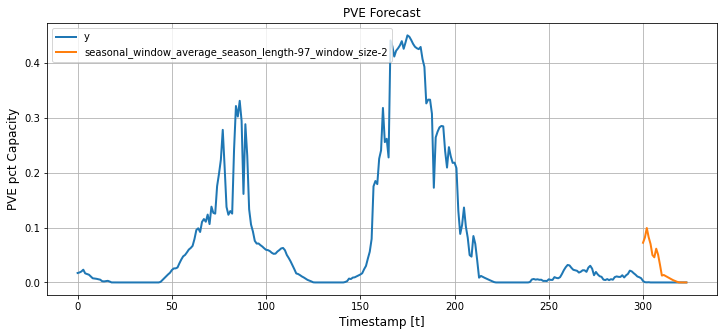

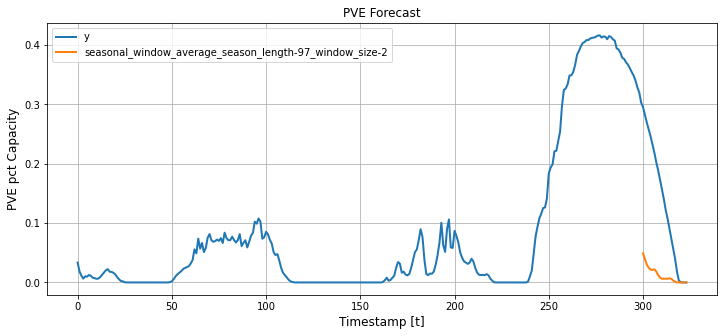

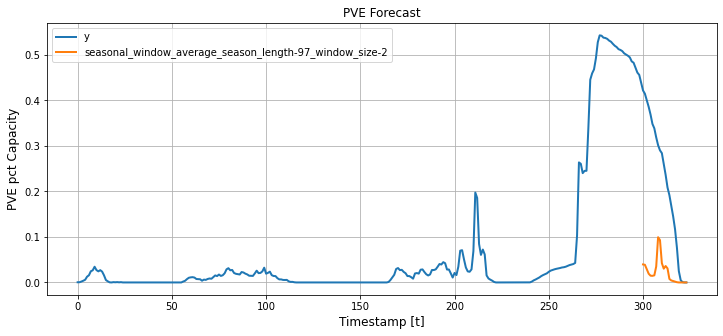

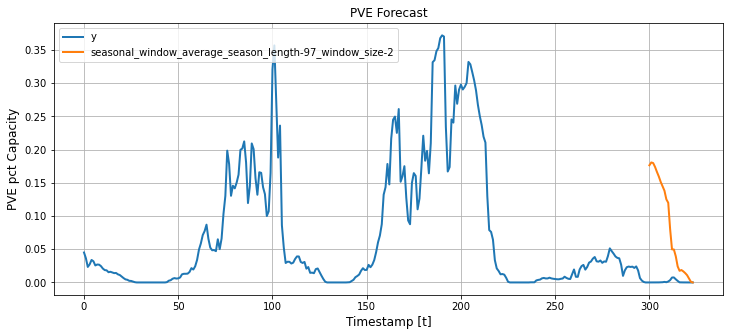

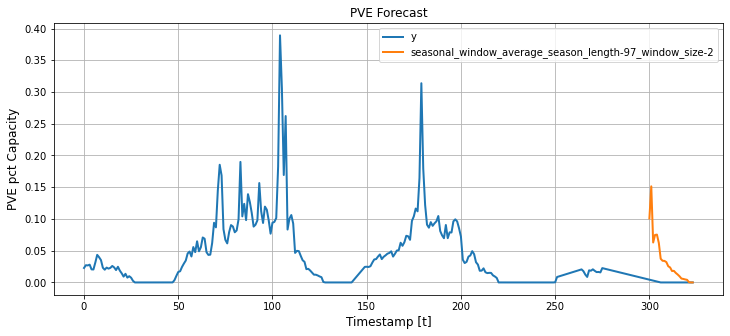

In [255]:
forecasts = forecasts.reset_index()
series_test = series_test.reset_index().merge(forecasts, how='left', on=['unique_id', 'ds'])

df_train = series_train.reset_index()
df_test = series_test

unique_ids = df_train['unique_id'].unique()
for uid in unique_ids:
    train_uid = df_train.query('unique_id == @uid')
    test_uid = df_test.query('unique_id == @uid')
    
    df_plot = pd.concat([train_uid, test_uid]).set_index('ds')
    df_plot[['y', 'seasonal_window_average_season_length-97_window_size-2']].plot(linewidth=2, figsize = (12,5))

    plt.title('PVE Forecast', fontsize=12)
    plt.ylabel('PVE pct Capacity', fontsize=12)
    plt.xlabel('Timestamp [t]', fontsize=12)
    plt.legend()
    plt.grid()

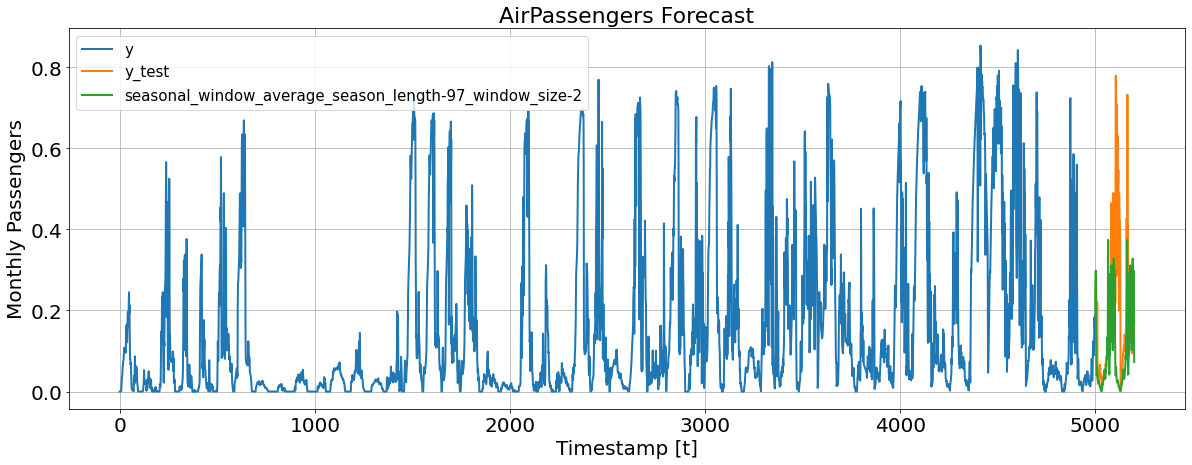

In [43]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
df_plot = pd.concat([series_train, forecasts]).set_index('ds')
df_plot[['y', 'y_test', 'seasonal_window_average_season_length-97_window_size-2']].plot(ax=ax, linewidth=2)
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)


# Seasonal Exp Smoothing

In [256]:
n_train = 300
n_test = 24
n_series = 10
train = data.iloc[-n_train-n_test: -n_test , :n_series]
test = data.iloc[-n_test: , :n_series]

series_train = pd.DataFrame({'ds': np.tile(np.arange(n_train) , n_series),'y': train.values.T.flatten()}, 
                            index=pd.Index(np.repeat(test.columns, n_train), name='unique_id'))
series_test = pd.DataFrame({'ds': np.tile(np.arange(n_train, n_train + n_test) , n_series),'y': test.values.T.flatten()}, 
                            index=pd.Index(np.repeat(test.columns, n_test), name='unique_id'))


models = [ (seasonal_exponential_smoothing,97, 0.5) ]


In [258]:
fcst = StatsForecast(series_train, models=models, freq='5min', n_jobs=8)

init = time.time()
with np.errstate(invalid='ignore'):
    forecasts = fcst.forecast(n_test, level = (80, 95))
end = time.time()

time_nixtla = end - init
print(f'time it took is {time_nixtla}')


time it took is 1.8438498973846436


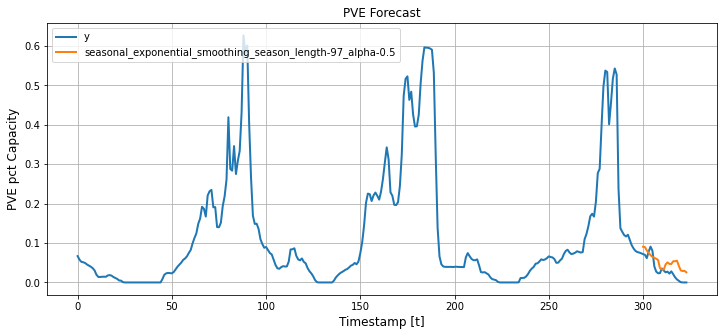

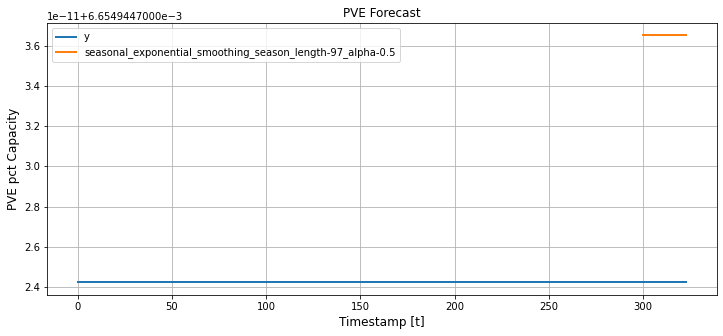

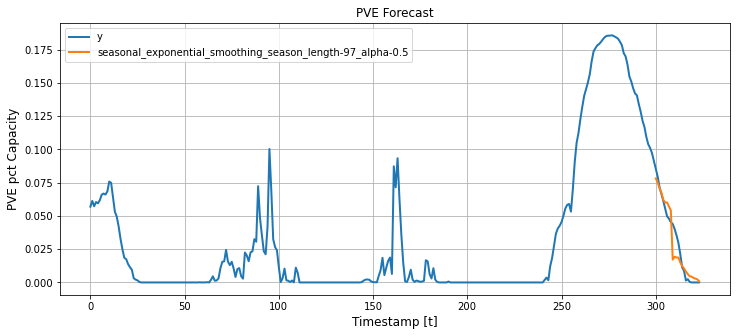

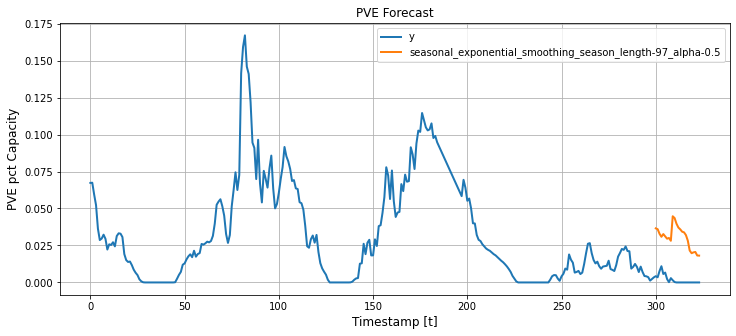

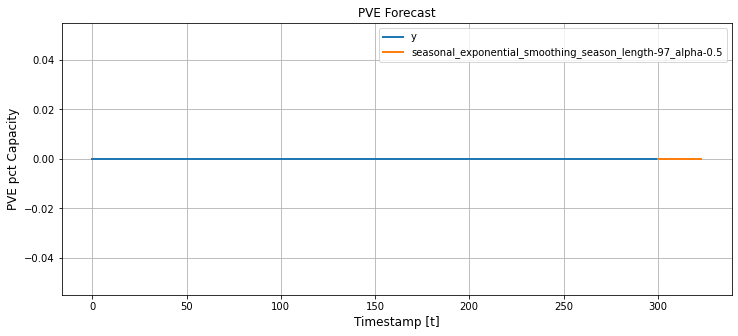

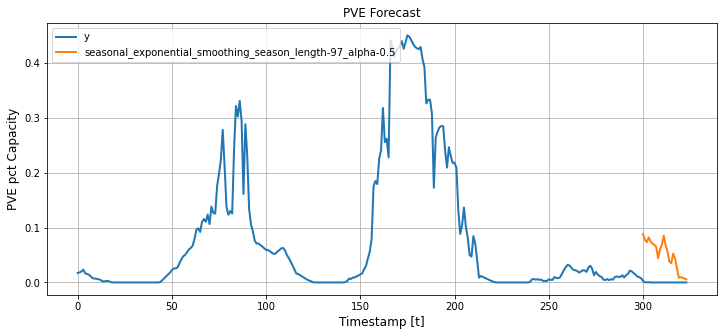

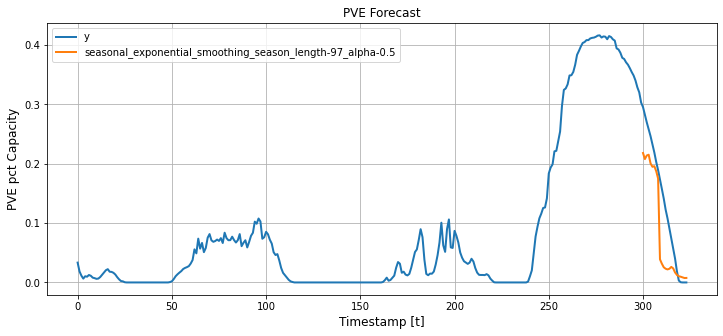

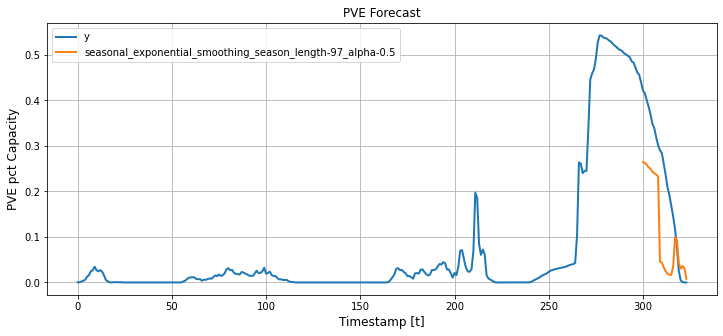

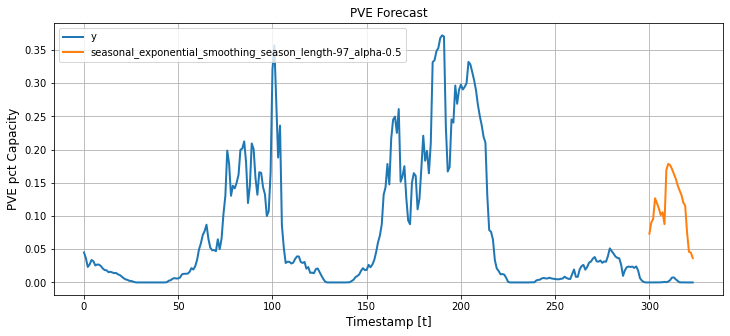

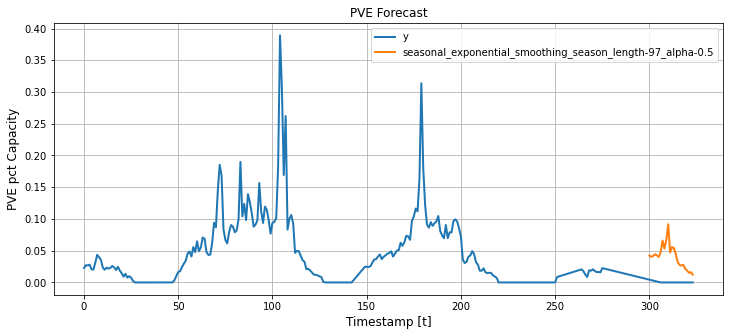

In [260]:
forecasts = forecasts.reset_index()
series_test = series_test.reset_index().merge(forecasts, how='left', on=['unique_id', 'ds'])

df_train = series_train.reset_index()
df_test = series_test

unique_ids = df_train['unique_id'].unique()
for uid in unique_ids:
    train_uid = df_train.query('unique_id == @uid')
    test_uid = df_test.query('unique_id == @uid')
    
    df_plot = pd.concat([train_uid, test_uid]).set_index('ds')
    df_plot[['y', 'seasonal_exponential_smoothing_season_length-97_alpha-0.5']].plot(linewidth=2, figsize = (12,5))

    plt.title('PVE Forecast', fontsize=12)
    plt.ylabel('PVE pct Capacity', fontsize=12)
    plt.xlabel('Timestamp [t]', fontsize=12)
    plt.legend()
    plt.grid()

## Single Exp Smoothing

In [275]:
n_train = 300
n_test = 24
n_series = 10
train = data.iloc[-n_train-n_test: -n_test , :n_series]
test = data.iloc[-n_test: , :n_series]

series_train = pd.DataFrame({'ds': np.tile(np.arange(n_train) , n_series),'y': train.values.T.flatten()}, 
                            index=pd.Index(np.repeat(test.columns, n_train), name='unique_id'))
series_test = pd.DataFrame({'ds': np.tile(np.arange(n_train, n_train + n_test) , n_series),'y': test.values.T.flatten()}, 
                            index=pd.Index(np.repeat(test.columns, n_test), name='unique_id'))
alpha = 0.80

models = [ (ses, alpha) ]


In [276]:
fcst = StatsForecast(series_train, models=models, freq='5min', n_jobs=8)

init = time.time()
with np.errstate(invalid='ignore'):
    forecasts = fcst.forecast(n_test, level = (80, 95))
end = time.time()

time_nixtla = end - init
print(f'time it took is {time_nixtla}')

time it took is 1.5757801532745361


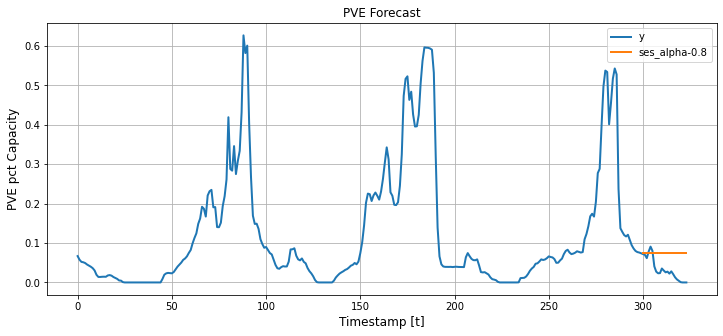

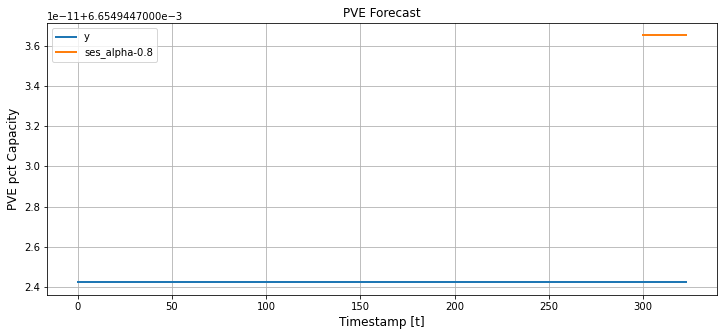

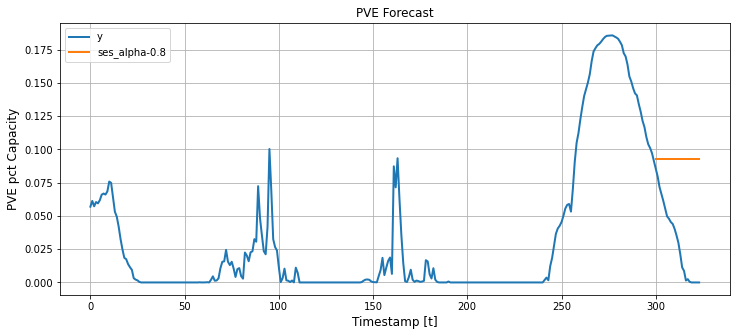

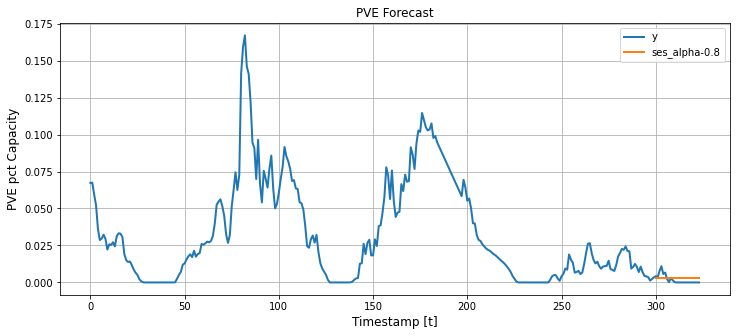

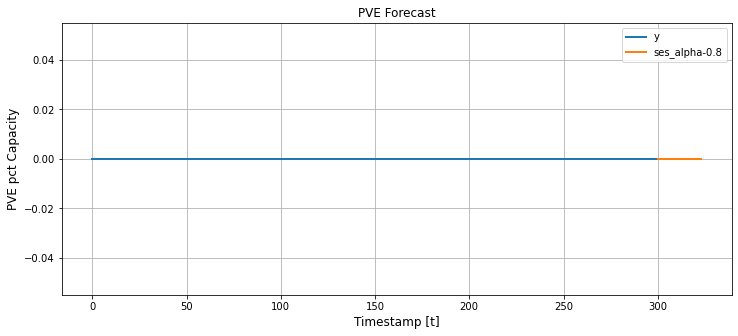

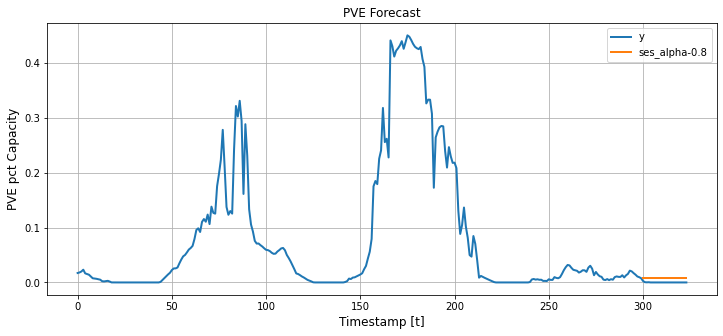

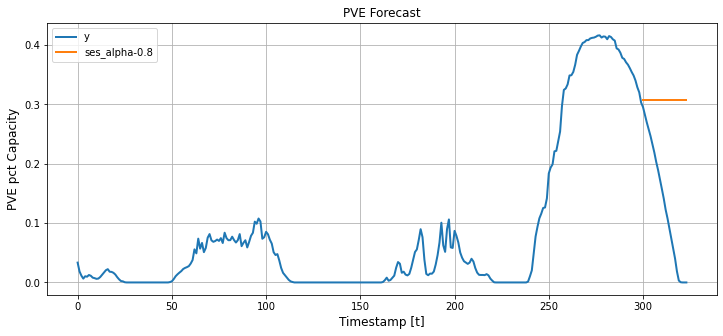

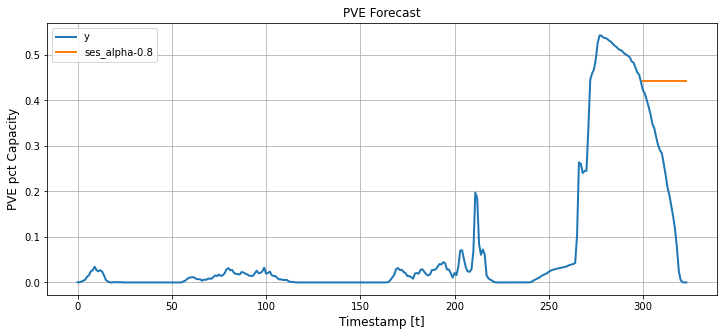

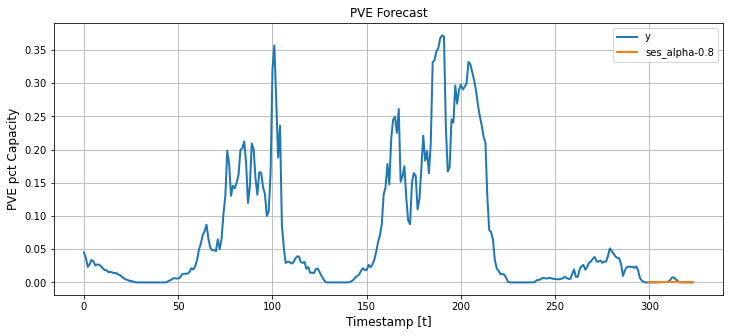

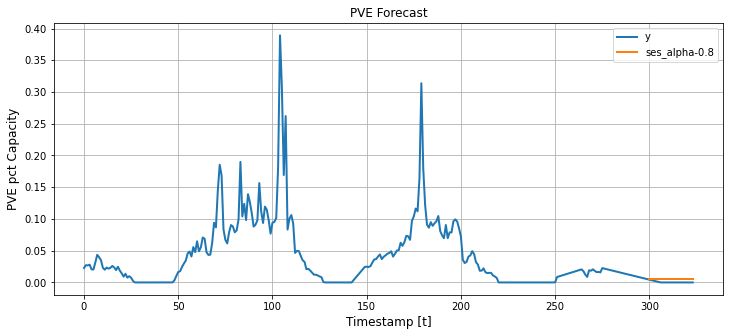

In [277]:
forecasts = forecasts.reset_index()
series_test = series_test.reset_index().merge(forecasts, how='left', on=['unique_id', 'ds'])

df_train = series_train.reset_index()
df_test = series_test

unique_ids = df_train['unique_id'].unique()
for uid in unique_ids:
    train_uid = df_train.query('unique_id == @uid')
    test_uid = df_test.query('unique_id == @uid')
    
    df_plot = pd.concat([train_uid, test_uid]).set_index('ds')
    df_plot[['y', f'ses_alpha-{alpha}']].plot(linewidth=2, figsize = (12,5))

    plt.title('PVE Forecast', fontsize=12)
    plt.ylabel('PVE pct Capacity', fontsize=12)
    plt.xlabel('Timestamp [t]', fontsize=12)
    plt.legend()
    plt.grid()